In [27]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import seed
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.callbacks import History
from sklearn.datasets import make_moons
from keras.callbacks import History
from keras.regularizers import l1
from mlxtend.plotting import plot_decision_regions
from keras.layers import BatchNormalization, Activation

In [3]:
seed(123)

Wczytanie danych, usunięcie brakujących wartości, nadanie etykiet

In [5]:
train_set = pd.read_csv('adult/adult.data', sep=", ",header = None, engine='python')
test_set = pd.read_csv('adult/adult.test', sep=", ",skiprows = 1, header = None, engine='python') 

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Szybki preprocessing

In [6]:
dataset = pd.concat([train, test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})

dataset.drop(["fnlwgt"], axis=1, inplace=True)
dataset.drop(["education"], axis=1, inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()
d = dict(pd.cut(x[x.index != " United-States"], 5, labels=range(5)))
dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset, drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class", axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class", axis=1)
y_test = test.wage_class

Standaryzacja

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f"X_train shape:\t{X_train.shape}")
print(f"X_test shape:\t{X_test.shape}")

X_train shape:	(30162, 41)
X_test shape:	(15060, 41)


In [13]:
# learning rate schedule, adjusts the learning rate over time
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

In [10]:
history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

2024-06-06 23:05:51.189588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-06 23:05:51.189756: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-06 23:05:51.189774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kjUbuntu): /proc/driver/nvidia/version does not exist
2024-06-06 23:05:51.195464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [11]:
model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

In [14]:
lrate = LearningRateScheduler(step_decay)   # adjust the learning rate over time
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1) # stop training when a monitored quantity has stopped improving
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])

Epoch 1/100
943/943 [==============================] - 4s 3ms/step - loss: 0.5892 - accuracy: 0.7171 - val_loss: 0.5236 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 2/100
943/943 [==============================] - 2s 2ms/step - loss: 0.5272 - accuracy: 0.7477 - val_loss: 0.4490 - val_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 3/100
943/943 [==============================] - 2s 2ms/step - loss: 0.4629 - accuracy: 0.7767 - val_loss: 0.3937 - val_accuracy: 0.8293 - lr: 1.0000e-04
Epoch 4/100
943/943 [==============================] - 2s 2ms/step - loss: 0.4262 - accuracy: 0.7935 - val_loss: 0.3715 - val_accuracy: 0.8355 - lr: 1.0000e-04
Epoch 5/100
943/943 [==============================] - 2s 2ms/step - loss: 0.4127 - accuracy: 0.8028 - val_loss: 0.3626 - val_accuracy: 0.8376 - lr: 1.0000e-04
Epoch 6/100
943/943 [==============================] - 2s 2ms/step - loss: 0.4020 - accuracy: 0.8084 - val_loss: 0.3577 - val_accuracy: 0.8379 - lr: 1.0000e-04
Epoch 7/100
943/943 [===================

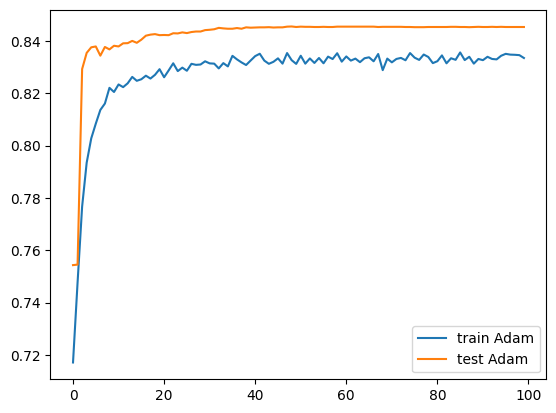

In [15]:
plt.plot(history_Adam.history['accuracy'], label = "train Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")
plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
```python
model.add(Dropout(0.8))
```
w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)

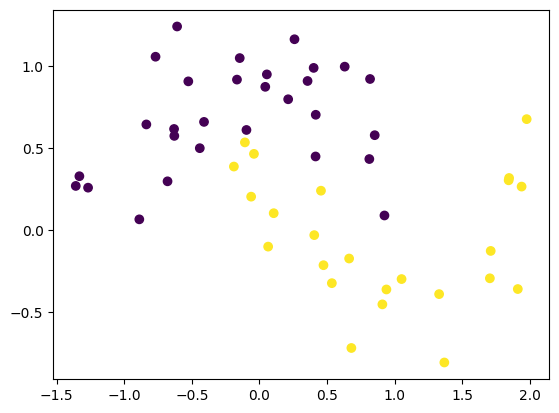

In [16]:
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [17]:
history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              3000      
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 200)               100200    
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 1s 171ms/step - loss: 0.7934 - accuracy: 0.4717 - val_loss: 0.8063 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [====================

In [18]:
history_Adam_dopout = History()
model_dropout = Sequential()
model_dropout.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model_dropout.add(Dropout(0.8))
model_dropout.add(Dense(500,activation="sigmoid"))
model_dropout.add(Dropout(0.8))
model_dropout.add(Dense(200,activation="sigmoid"))
model_dropout.add(Dropout(0.8))
model_dropout.add(Dense(1,activation="sigmoid"))
model_dropout.summary()

model_dropout.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model_dropout.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_dopout])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              3000      
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 200)               100200    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

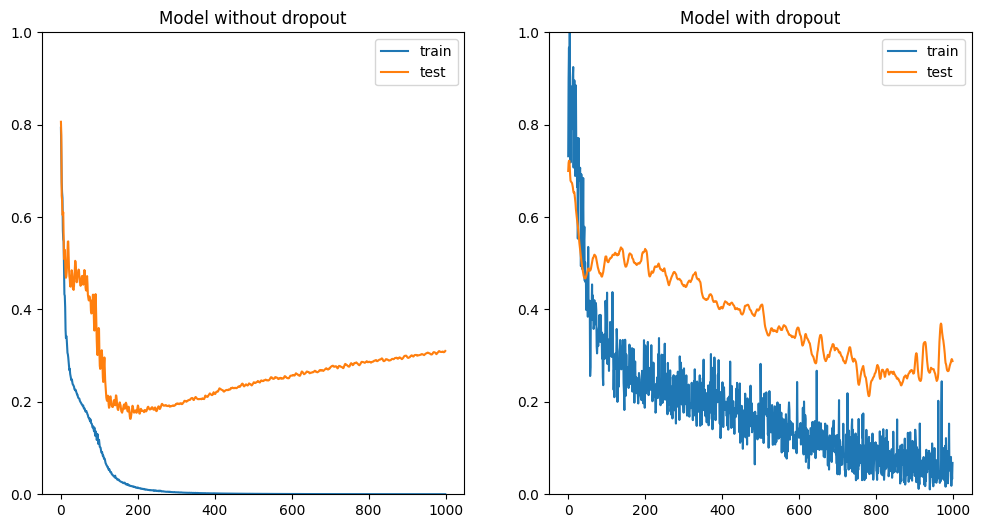

In [24]:
_, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(history_Adam.history['loss'], label = "train")
ax[0].plot(history_Adam.history['val_loss'], label = "test")
ax[0].set_title('Model without dropout')
ax[0].legend()
ax[0].set_ylim(0,1)

ax[1].plot(history_Adam_dopout.history['loss'], label = "train")
ax[1].plot(history_Adam_dopout.history['val_loss'], label = "test")
ax[1].set_title('Model with dropout')
ax[1].legend()
ax[1].set_ylim(0,1)

plt.legend()
plt.show()

22500/22500 [==============================] - 58s 3ms/step


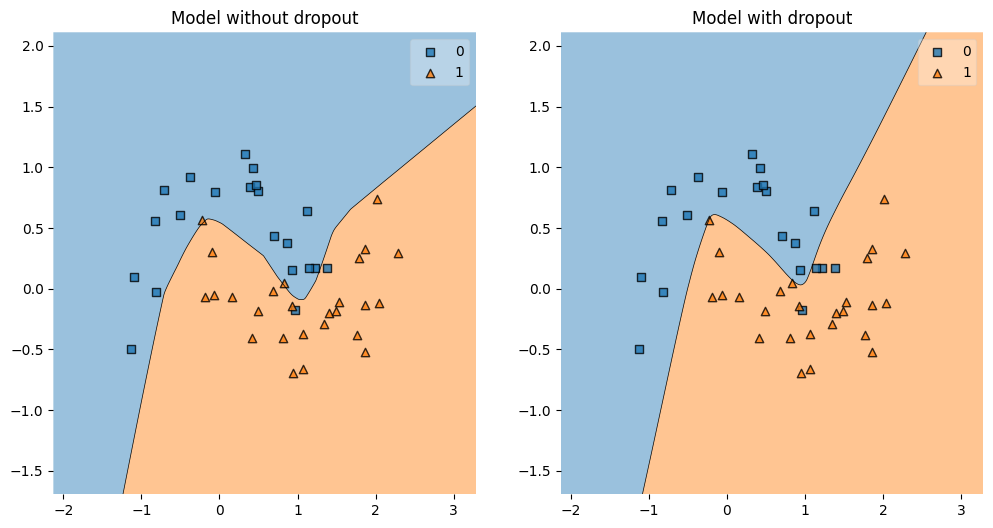

In [26]:
_, ax = plt.subplots(1,2, figsize=(12,6))

plot_decision_regions(X_test, y_test, model, ax=ax[0])
ax[0].set_title('Model without dropout')

plot_decision_regions(X_test, y_test, model_dropout, ax=ax[1])
ax[1].set_title('Model with dropout')

plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)
* porównaj do powyższego eksperymentu

In [28]:
history_batch_droput = History()
model_batch_droput = Sequential()

model_batch_droput.add(Dense(1000, input_shape=(X_train.shape[1],)))
model_batch_droput.add(BatchNormalization())
model_batch_droput.add(Activation("relu"))
model_batch_droput.add(Dropout(0.3))

model_batch_droput.add(Dense(500))
model_batch_droput.add(BatchNormalization())
model_batch_droput.add(Activation("sigmoid"))
model_batch_droput.add(Dropout(0.3))

model_batch_droput.add(Dense(200))
model_batch_droput.add(BatchNormalization())
model_batch_droput.add(Activation("sigmoid"))
model_batch_droput.add(Dropout(0.3))

model_batch_droput.add(Dense(1))
model_batch_droput.add(BatchNormalization())
model_batch_droput.add(Activation("sigmoid"))
model.summary()

model_batch_droput.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model_batch_droput.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_batch_droput])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              3000      
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 200)               100200    
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 2s 210ms/step - loss: 0.7804 - accuracy: 0.5472 - val_loss: 0.6988 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [====================

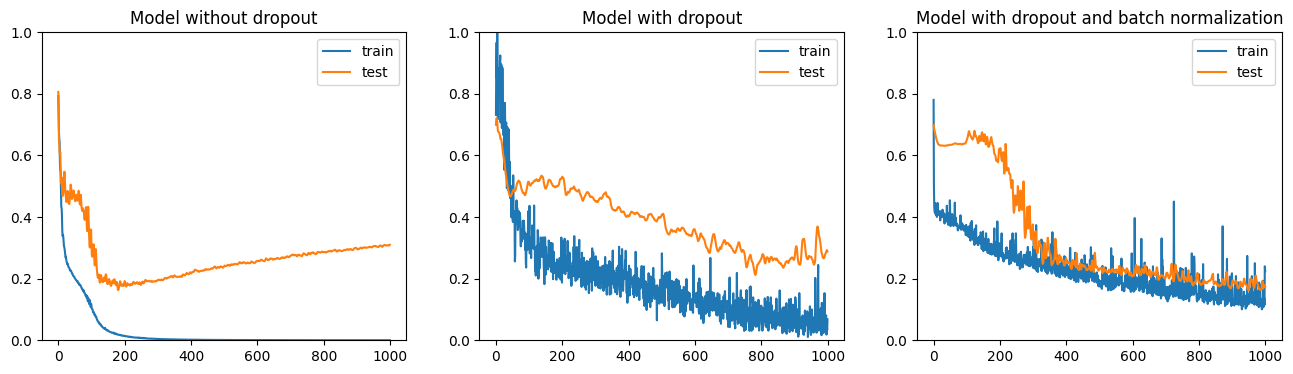

In [35]:
_, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].plot(history_Adam.history['loss'], label = "train")
ax[0].plot(history_Adam.history['val_loss'], label = "test")
ax[0].set_title('Model without dropout')
ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(history_Adam_dopout.history['loss'], label = "train")
ax[1].plot(history_Adam_dopout.history['val_loss'], label = "test")
ax[1].set_title('Model with dropout')
ax[1].set_ylim(0,1)
ax[1].legend()

ax[2].plot(history_batch_droput.history['loss'], label = "train")
ax[2].plot(history_batch_droput.history['val_loss'], label = "test")
ax[2].set_title('Model with dropout and batch normalization')
ax[2].set_ylim(0,1)
ax[2].legend()

plt.show()

20000/20000 [==============================] - 102s 5ms/step


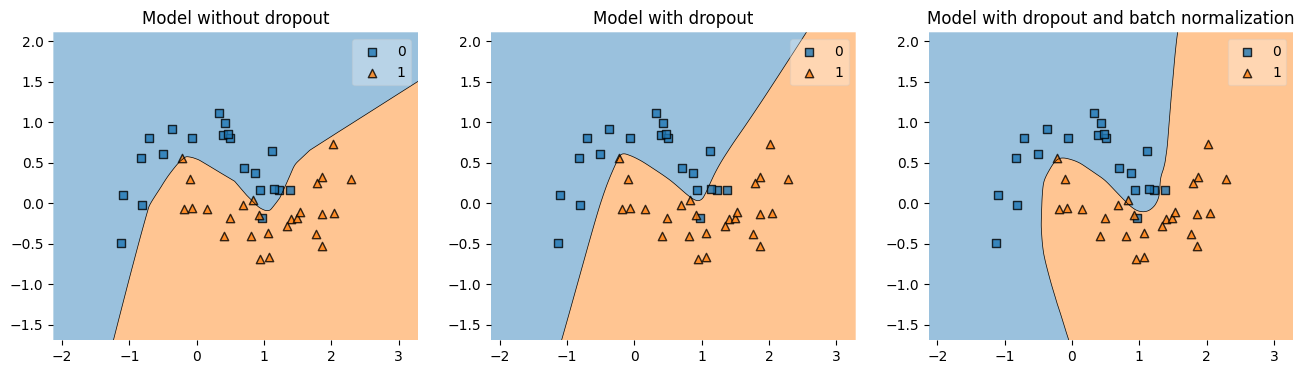

In [37]:
_, ax = plt.subplots(1,3, figsize=(16,4))

plot_decision_regions(X_test, y_test, model, ax=ax[0])
ax[0].set_title('Model without dropout')

plot_decision_regions(X_test, y_test, model_dropout, ax=ax[1])
ax[1].set_title('Model with dropout')

plot_decision_regions(X_test, y_test, model_batch_droput, ax=ax[2])
ax[2].set_title('Model with dropout and batch normalization')

plt.show()

# Regularyzacja

# Zad.
Do modelu dodaj 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [ ]:
history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1000)              3000      
                                                                 
 dense_17 (Dense)            (None, 500)               500500    
                                                                 
 dense_18 (Dense)            (None, 200)               100200    
                                                                 
 dense_19 (Dense)            (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 3s 359ms/step - loss: 0.8500 - accuracy: 0.5472 - val_loss: 0.6803 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [====================

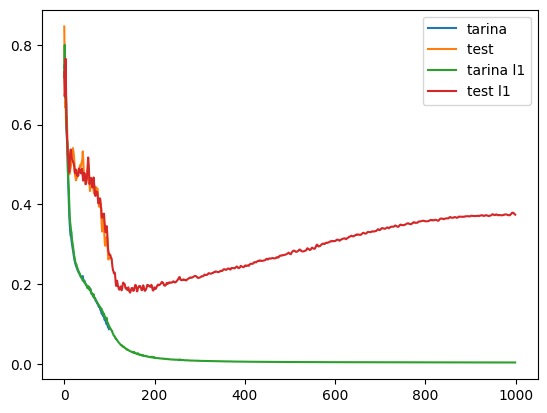

In [13]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

9600/9600 [==============================] - 15s 2ms/step


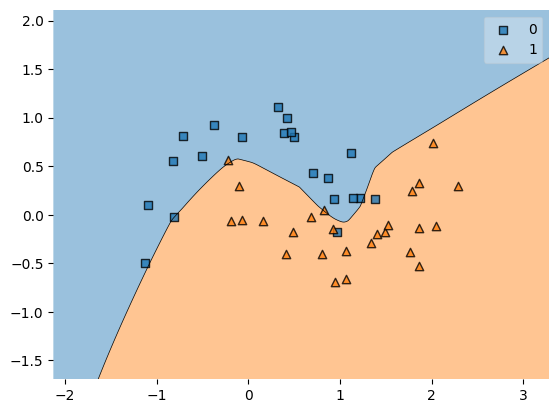

In [14]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

Batch działa w taki sposób, że dla danego batcha liczy w warstawie w której jest ustawiony srednia i wariancje funkcji aktywacji danego neuronu. Następnie normalizuje dane i ustawia parametry g i b. g * (x - mean) / sqrt(var + epsilon) + b. W ten sposób uczenie jest bardziej stabilne i szybsze. Dropout działa w taki sposób, że dla danego batcha losuje neurony, które nie będą uczestniczyć w uczeniu. W ten sposób model jest bardziej odporny na overfitting.